### Visualization of proposed pipeline running on learned traction PMFs (pre-generated from NN with softmax output).

Load pre-generated TDM based on neural network trained based on real world bags. Load two different TDMs---one "ground truth" and the other one is robot's prediction. Robot can used the associated GMM confidence score to rule out region with low confidence.

In [16]:
%matplotlib inline
import time
import math
import copy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
sys.path.insert(0, '../mppi_numba')
from mppi_numba.density import Density, GaussianMixture
from mppi_numba.terrain import Terrain, TDM_Numba, TractionGrid
from mppi_numba.visualization import TDM_Visualizer, vis_density, vis_density_as_pmf
from mppi_numba.mppi import MPPI_Numba
from mppi_numba.config import Config
import pickle
import os


In [17]:
trained_folder = "tdm_models/predicted"
trained_model_subfolder = "fells_nn_predicts_wp_forest1"
gt_folder = "tdm_models/ground_truth" # "tdm_models/ground_truth"
gt_model_subfolder = "wp_forest1"
# -----------------------------------------------------------------


with open(os.path.join(trained_folder, trained_model_subfolder, "tdm_info.pickle" ), 'rb') as fh:
  pred_tdm_info = pickle.load(fh)
  print(pred_tdm_info.keys())

with open(os.path.join(gt_folder, gt_model_subfolder, "tdm_info.pickle"), 'rb') as fh:
  gt_tdm_info = pickle.load(fh)


id2rgb_map = gt_tdm_info['id2rgb_map']
rgb2id_map = gt_tdm_info['rgb2id_map']
id2rgb_map[-1] = (0,0,0)
rgb2id_map[(0,0,0)] = -1
id2rgb_map = {k: np.array(v)/255 for k, v in id2rgb_map.items()}
rgb2id_map = {np.array(v)/255: v for k, v in rgb2id_map.items()}
w = gt_tdm_info['width']
h = gt_tdm_info['height']

# TODO: only visualize partially based on known areas
semantic_grid = gt_tdm_info['color_indices'] 

# For places where we don't have access to ground truth, also mask away the same region in the predicted map.
gt_unknown = gt_tdm_info["unknown_colors_mask"]
pred_tdm_info["unknown_colors_mask"][gt_unknown] = 1
pred_tdm_info["unknown_colors_mask"][gt_unknown] = 1
# Adjust the PMF
pred_tdm_info["lin_pmf_grid"][0,gt_unknown] = 100
pred_tdm_info["lin_pmf_grid"][1:,gt_unknown] = 0
pred_tdm_info["ang_pmf_grid"][0,gt_unknown] = 100
pred_tdm_info["ang_pmf_grid"][1:,gt_unknown] = 0
# For places where ground truth is 0 traction, we mask away the predicted map as well
gt_no_traction_mask = gt_tdm_info["lin_pmf_grid"][0,:,:]==100
pred_tdm_info["lin_pmf_grid"][0,gt_no_traction_mask]=100
pred_tdm_info["lin_pmf_grid"][1:,gt_no_traction_mask]=0
pred_tdm_info["ang_pmf_grid"][0,gt_no_traction_mask]=100
pred_tdm_info["ang_pmf_grid"][1:,gt_no_traction_mask]=0

dict_keys(['xlimits', 'ylimits', 'res', 'bin_values', 'bin_values_bounds', 'height', 'width', 'lin_pmf_grid', 'ang_pmf_grid', 'normalized_confidence', 'color_indices', 'color_mask', 'unknown_colors_mask', 'elevation', 'id2rgb_map', 'rgb2id_map'])


In [18]:
# Can generate the TDM object

def reset_tdm_from_info(lin_tdm, ang_tdm, tdm_info, alpha_dyn, obstacle_map=None, unknown_map=None):

  tdm_params = {
    "xlimits": tdm_info['xlimits'],
    "ylimits": tdm_info['ylimits'],
    "res": tdm_info['res'],
    "bin_values": tdm_info['bin_values'],
    "bin_values_bounds": tdm_info['bin_values_bounds'],
    "det_dynamics_cvar_alpha": alpha_dyn,
  }
  
  lin_tdm.reset()
  ang_tdm.reset()
  lin_tdm.set_TDM_from_PMF_grid(tdm_info['lin_pmf_grid'], tdm_params, obstacle_map=obstacle_map, unknown_map=unknown_map)
  ang_tdm.set_TDM_from_PMF_grid(tdm_info['ang_pmf_grid'], tdm_params, obstacle_map=obstacle_map, unknown_map=unknown_map)

def sample_traction_grid(lin_tdm, ang_tdm):
  # TODO: need to get padded xlimits and padded width and height
  # Sample a specific map from the ground truth distribution
  lin_traction_grid_int8 = lin_tdm.sample_grids().copy_to_host()[0]
  lin = lin_traction_grid_int8*(lin_tdm.bin_values_bounds[1]-lin_tdm.bin_values_bounds[0])/100.0+lin_tdm.bin_values_bounds[0]

  ang_traction_grid_int8 = ang_tdm.sample_grids().copy_to_host()[0]
  ang = ang_traction_grid_int8*(ang_tdm.bin_values_bounds[1]-ang_tdm.bin_values_bounds[0])/100.0+ang_tdm.bin_values_bounds[0]

  res = lin_tdm.res
  return TractionGrid(lin, ang, res, use_int8=False, xlimits=lin_tdm.padded_xlimits, ylimits=lin_tdm.padded_ylimits)  


def visualize_useful_info(lin_tdm, ang_tdm, gt_tdm_info, pred_tdm_info, figsize=(5,5)):


  lin_tdm_vis = TDM_Visualizer(lin_tdm, tdm_contains_semantic_grid=False)
  ang_tdm_vis = TDM_Visualizer(ang_tdm, tdm_contains_semantic_grid=False)

  # Visualize the semantics
  fig, ax = lin_tdm_vis.draw(figsize=figsize, semantic_grid=semantic_grid, id2rgb_map=id2rgb_map)

  # # Visualize the height map
  # fig, ax = plt.subplots()
  # # lin = traction_grid.lin_traction
  # img = ax.imshow(gt_tdm_info['elevation'], origin='lower', vmin=0, vmax=1.0, cmap='gray')
  # ax.set_title('elevation')
  # divider = make_axes_locatable(ax)
  # cax = divider.append_axes("right", size="5%", pad=0.05)
  # plt.colorbar(img, cax=cax)
  # plt.show()

  # Sample a specific map from the distribution that can be used to update the robot state
  traction_grid = sample_traction_grid(lin_tdm, ang_tdm)
  lin = traction_grid.lin_traction
  ang = traction_grid.ang_traction
  fig, ax = plt.subplots(figsize=figsize)
  # lin = traction_grid.lin_traction
  img = ax.imshow(lin, origin='lower', vmin=0, vmax=1.0, cmap='gray')
  ax.set_title('sampled linear traction')
  ax.axis('off')
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  plt.colorbar(img, cax=cax)
  plt.show()

  fig, ax = plt.subplots(figsize=figsize)
  img = ax.imshow(pred_tdm_info['unknown_colors_mask'], origin='lower', vmin=0, vmax=1.0, cmap='gray')
  ax.set_title("predictor's unknown color mask")
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  plt.colorbar(img, cax=cax)
  plt.show()

  fig, ax = plt.subplots(figsize=figsize)
  img = ax.imshow(ang, origin='lower', vmin=0, vmax=1, cmap='gray')
  ax.set_title('sampled angular traction')
  ax.axis('off')
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  plt.colorbar(img, cax=cax)
  plt.show()

  # Likelihood score plot with heatmap
  fig, ax = plt.subplots(figsize=figsize)
  # lin = traction_grid.lin_traction
  img = ax.imshow(pred_tdm_info['normalized_confidence'], origin='lower', vmin=0, vmax=1.0, cmap='gray', alpha=1.0)
  ctr = ax.contourf(pred_tdm_info['normalized_confidence'],
                   levels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 
                  # levels=[0.0, 0.3, 0.6, 1.0], 
                  #  cmap="YlOrRd_r",
                  cmap="Reds_r",
                  #  cmap="viridis",
                  alpha=0.9, antialiased=True)
  ax.set_title("Predictor's Confidence Score")
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  # plt.colorbar(img, cax=cax)
  plt.colorbar(ctr, cax=cax)
  plt.show()


In [19]:
max_speed = 3.0
use_tdm = True # True # True
use_det_dynamics = False # True
use_nom_dynamics_with_speed_map = False # 
use_costmap = False

# ------ General configs for both MPPI and TDM ------
cfg_kwargs = dict(
  T = 10.0,
  dt = 0.1,
  num_grid_samples =  1024,
  num_control_rollouts = 1024,
  max_speed_padding = max_speed+2.0,
  num_vis_state_rollouts = 100,
  max_map_dim =(150, 100),
  seed = 1,
  use_tdm = use_tdm,
  use_det_dynamics = use_det_dynamics,
  use_nom_dynamics_with_speed_map = use_nom_dynamics_with_speed_map,
  use_costmap = use_costmap,
)
cfg = Config(**cfg_kwargs)


x0=np.array([12.0, 15.0, 0])
xgoal= np.array([20, -5])
goal_tolerance = 2.0
mppi_params = dict(
    # Task specification
    dt=cfg.dt,
    x0=x0,
    xgoal=xgoal,

    # For risk-aware min time planning
    goal_tolerance=goal_tolerance,
    v_post_rollout=0.01,
    cvar_alpha=1.0, # use the mean of objectives if cvar_alpha=1.0
    alpha_dyn=1.0, # sample tractions from worst alpha_dyn-percentile  (mostly for TDM)

    dist_weight=1.0,

    # Hyper parameters
    lambda_weight=1.0,
    num_opt=1, # how many steps in each solve() function call

    # Control and sample specification
    u_std=np.array([2.0, 2.0]), # angular part affects how much robot turns to squeeze through gaps
    vrange = np.array([0.0, max_speed]), 
    wrange=np.array([-np.pi, np.pi]),
)

gt_lin_tdm = TDM_Numba(cfg)
gt_ang_tdm = TDM_Numba(cfg)
pred_lin_tdm = TDM_Numba(cfg)
pred_ang_tdm = TDM_Numba(cfg)
mppi_planner = MPPI_Numba(cfg)
reset_tdm_from_info(gt_lin_tdm, gt_ang_tdm, gt_tdm_info, mppi_params['alpha_dyn'])
reset_tdm_from_info(pred_lin_tdm, pred_ang_tdm, pred_tdm_info, mppi_params['alpha_dyn'])

TDM has initialized GPU memory after 0.05617690086364746 s
TDM has initialized GPU memory after 0.040859222412109375 s
TDM has initialized GPU memory after 0.04286789894104004 s
TDM has initialized GPU memory after 0.040773630142211914 s
MPPI planner has initialized GPU memory after 0.016164779663085938 s


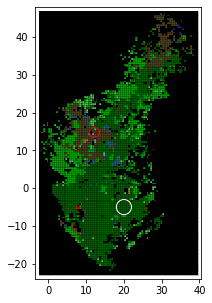

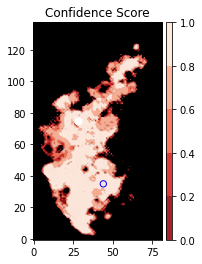

In [20]:

mppi_params = dict(
    # Task specification
    dt=cfg.dt,
    x0=x0,
    xgoal=xgoal,

    # For risk-aware min time planning
    goal_tolerance=goal_tolerance,
    v_post_rollout=0.1,
    cvar_alpha=1.0, # use the mean of objectives if cvar_alpha=1.0
    alpha_dyn=1.0, # sample tractions from worst alpha_dyn-percentile  (mostly for TDM)

    dist_weight=1.0,

    # Hyper parameters
    lambda_weight=1.0,
    num_opt=1, # how many steps in each solve() function call

    # Control and sample specification
    u_std=np.array([2.0, 3.0]), # angular part affects how much robot turns to squeeze through gaps
    vrange = np.array([0.0, max_speed]), 
    wrange=np.array([-np.pi, np.pi]),
)

lin_tdm_vis = TDM_Visualizer(gt_lin_tdm, tdm_contains_semantic_grid=False)
fig, ax = lin_tdm_vis.draw(figsize=(5, 5), semantic_grid=semantic_grid, id2rgb_map=id2rgb_map)
ax.plot([x0[0]], [x0[1]], 'ro', markersize=10, markerfacecolor='none', label="Start")
c1 = plt.Circle(xgoal, mppi_params['goal_tolerance'], color='w', fill=False, label="Goal", zorder=6)
ax.add_patch(c1)
plt.axis("on")

fig, ax = plt.subplots()
img = ax.imshow(pred_tdm_info['normalized_confidence'], origin='lower', vmin=0, vmax=1.0, cmap='gray', alpha=1.0)
ctr = ax.contourf(pred_tdm_info['normalized_confidence'],
                 levels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 
                # levels=[0.0, 0.3, 0.6, 1.0], 
                #  cmap="YlOrRd_r",
                cmap="Reds_r",
                #  cmap="viridis",
                alpha=0.9, antialiased=True)
hm_x0 = copy.deepcopy(x0)
hm_xgoal = copy.deepcopy(xgoal)
hm_x0[0] = (hm_x0[0] - gt_lin_tdm.xlimits[0])/gt_lin_tdm.res
hm_x0[1] = (hm_x0[1] - gt_lin_tdm.ylimits[0])/gt_lin_tdm.res
hm_xgoal[0] = (hm_xgoal[0] - gt_lin_tdm.xlimits[0])/gt_lin_tdm.res
hm_xgoal[1] = (hm_xgoal[1] - gt_lin_tdm.ylimits[0])/gt_lin_tdm.res

ax.scatter([hm_x0[0]], [hm_x0[1]], c='white', s=50)
c1 = plt.Circle(hm_xgoal, mppi_params['goal_tolerance'], color='b', fill=False, label="Goal", zorder=6)
ax.add_patch(c1)
# ax.scatter([xgoal[0]], [xgoal[1]], c='white', s=50, filled=False)
ax.set_title('Confidence Score')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
# plt.colorbar(img, cax=cax)
plt.colorbar(ctr, cax=cax)
plt.show()


## Create GIF of rollouts given different confidence thresholds

If not animated in notebook, the gif can be found in example_gifs folder.

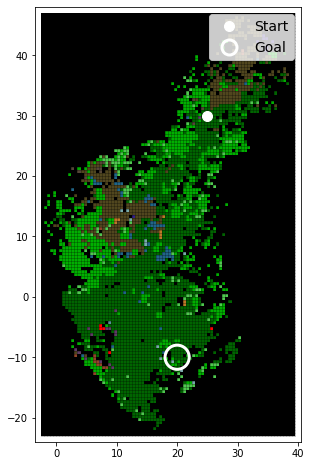

In [22]:
# Visualize the environment
x0 = np.array([25, 30, 0])
xgoal = np.array([20, -10])

fontsize=15
lin_tdm_vis = TDM_Visualizer(gt_lin_tdm, tdm_contains_semantic_grid=False)
fig, ax = lin_tdm_vis.draw(figsize=(8, 8), semantic_grid=semantic_grid, id2rgb_map=id2rgb_map)
ax.plot([x0[0]], [x0[1]], 'wo', markersize=10, label="Start")
c1 = plt.Circle(xgoal, mppi_params['goal_tolerance'], color='w', linewidth=3, fill=False, zorder=6) # label="Goal",
ax.plot([], [], 'wo', markersize=15, markerfacecolor="none", markeredgewidth=3, label="Goal")
ax.add_patch(c1)
ax.axis("on")
ax.legend(fontsize=fontsize-1)

TDM has initialized GPU memory after 0.07871747016906738 s
TDM has initialized GPU memory after 0.04079771041870117 s
TDM has initialized GPU memory after 0.040253639221191406 s
TDM has initialized GPU memory after 0.04017996788024902 s
MPPI planner has initialized GPU memory after 0.01630234718322754 s
using gt, trial (1/1)


/home/jeremy/.local/lib/python3.8/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/jeremy/.local/lib/python3.8/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


thres=0.0 (1/3), trial (1/1)
thres=0.3 (2/3), trial (1/1)
thres=0.6 (3/3), trial (1/1)


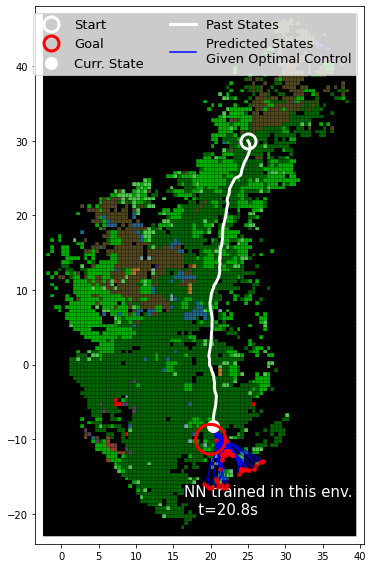

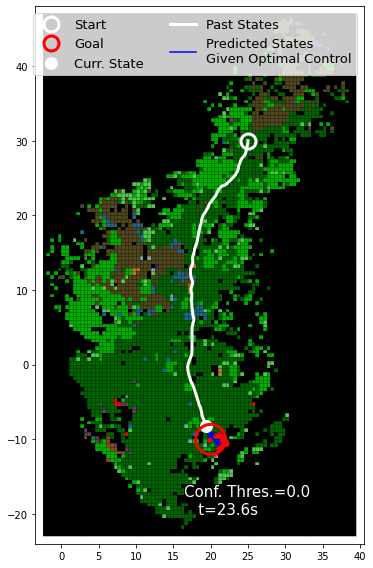

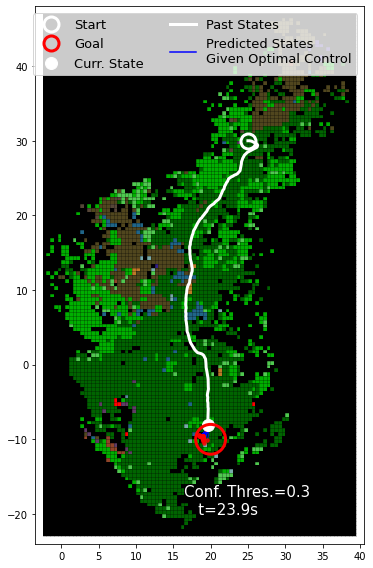

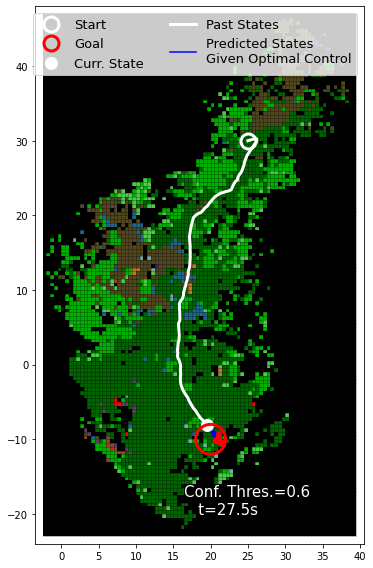

In [23]:
# Trial function
def trial(mppi_planner, pred_lin_tdm, traction_grid, dt, max_steps, mppi_params,num_vis_state_rollouts, gif_txt=""):
  
  fontsize=15
  x0 = mppi_params['x0']
  xgoal = mppi_params['xgoal']
  xhist = np.zeros((max_steps+1, 3))*np.nan
  uhist = np.zeros((max_steps, 2))*np.nan
  xhist[0] = mppi_params['x0']
  goal_reached = False
  dist_to_goal = np.nan
  cum_obj = 0
  cum_dist_to_goal = 0

  # Other objects for animation
  lin_tdm_vis = TDM_Visualizer(pred_lin_tdm, tdm_contains_semantic_grid=False)
  fig, ax = lin_tdm_vis.draw(figsize=(8, 8), semantic_grid=semantic_grid, id2rgb_map=id2rgb_map)
  ax.plot([mppi_params['x0'][0]], [mppi_params['x0'][1]], 'wo', markersize=15, markeredgewidth=3, markerfacecolor='none', label="Start")
  c1 = plt.Circle(mppi_params['xgoal'], mppi_params['goal_tolerance'], color='r', linewidth=3, fill=False, zorder=6)
  ax.add_patch(c1)
  circle_dummy = ax.plot([], [], 'ro', markersize=15, markerfacecolor="none", markeredgewidth=3, label="Goal")
  l_curr, = ax.plot([x0[0]], [x0[1]], 'wo', markersize=12, label="Curr. State", zorder=5)
  l_past, = ax.plot(xhist[:,0], xhist[:,1], 'w', linewidth=3, label="Past States")
  l_rollout_end, = ax.plot([x0[0]], [x0[1]], 'r.', alpha=0.8, markersize=7, zorder=4)
  l_rollout_list = []
  for i in range(num_vis_state_rollouts):
    l_rollout, = ax.plot([[x0[0]], [x0[0]]], [[x0[1]], [x0[1]]], 'b', lw=1, alpha=0.8, zorder=3)
    l_rollout_list.append(l_rollout)

  # thandle = ax.set_title("t={:.1f}s".format(0), fontsize=fontsize, x=0.5, y=0.95)
  ax.plot([1e6], [1e6], 'b-', label="Predicted States\nGiven Optimal Control")

  txth = ax.text(16.5, -20, "{}\n   t=0s".format(gif_txt), color='w', fontsize=15)
  ax.axis("on")
  ax.legend(fontsize=fontsize-2, ncol=2)
  goal_reached = False


  def animate(t):

    # If goal reached to begin with, return
    dist_to_goal = np.linalg.norm(xhist[t, :2] - mppi_params['xgoal']) - mppi_params['goal_tolerance']
    if dist_to_goal>0:
      

      # Solve
      useq = mppi_planner.solve()
      u_curr = useq[0]
      uhist[t] = u_curr

      # Simulate state forward using the sampled map
      lt, at = traction_grid.get(xhist[t,0], xhist[t,1])
      xhist[t+1, 0] = xhist[t, 0] + dt*lt*np.cos(xhist[t, 2])*u_curr[0]
      xhist[t+1, 1] = xhist[t, 1] + dt*lt*np.sin(xhist[t, 2])*u_curr[0]
      xhist[t+1, 2] = xhist[t, 2] + dt*at*u_curr[1]
      
      # -------------- Start plotting -----------------------
      l_curr.set_data([xhist[t+1, 0]], [xhist[t+1, 1]])

      # Get rollout states from subset of maps for visualization? (e.g., 50)
      rollout_states_vis = mppi_planner.get_state_rollout()
      l_past.set_data(xhist[:,0], xhist[:,1])
      l_rollout_end.set_data(rollout_states_vis[:,-1,0].T, rollout_states_vis[:,-1,1].T)
      for l_rollout, rollout in zip(l_rollout_list, rollout_states_vis):
        l_rollout.set_data(rollout[:,0], rollout[:,1])
      # For the legends
      
      txth.set_text("{}\n   t={:.1f}s".format(gif_txt, dt*t))
      plt.tight_layout()

      # -------------- End plotting -------------------------

      # Update MPPI state (x0, useq)
      mppi_planner.shift_and_update(xhist[t+1], useq, num_shifts=1)
      # Accumulate stage cost 
      dist_to_goal = np.linalg.norm(xhist[t+1, :2] - mppi_params['xgoal']) - mppi_params['goal_tolerance']

  # Animation
  anim = animation.FuncAnimation(fig, animate, 
                                interval=int(mppi_params['dt']*1e3), # delay between frames in milliseconds
                                frames=max_steps)  
  return anim



"""
Use the same TDM algorithm but we adjust the confidence tolerance and adjust he PMF used for sampling
"""
def all_trials(start_goal_pairs, mppi_planner, pred_lin_tdm, pred_ang_tdm, pred_tdm_info,
  gt_lin_tdm, gt_ang_tdm, max_steps, num_trials, confidence_thres_list, default_mppi_params, num_vis_state_rollouts):

  loggers = []
  # Firstly, sample traction from the GROUNDTRUTH!
  # Pregenerate num_trials of traction map
  traction_grid_list = [sample_traction_grid(gt_lin_tdm, gt_ang_tdm) for i in range(num_trials)] 


  # Loop trials
  for start_goal_i, (x0, xgoal) in enumerate(start_goal_pairs):
    mppi_params = copy.deepcopy(default_mppi_params)
    mppi_params['x0'] = x0
    mppi_params['xgoal'] = xgoal

    for trial_i, traction_grid in enumerate(traction_grid_list):

      # Run trials for gt dynamics
      print("using gt, trial ({}/{})".format(
        trial_i+1, num_trials
      ))
      t0 = time.time()
      # Construct the MPPI planner + initialize the GPU variables
      gt_lin_tdm.reset()
      gt_ang_tdm.reset()
      mppi_planner.reset()

      reset_tdm_from_info(gt_lin_tdm, gt_ang_tdm, gt_tdm_info, mppi_params['alpha_dyn'])
      mppi_planner.setup(mppi_params, gt_lin_tdm, gt_ang_tdm)
      anim = trial(mppi_planner, gt_lin_tdm, traction_grid, cfg.dt, max_steps, mppi_params, 
                  num_vis_state_rollouts, gif_txt="NN trained in this env.")
      name = "gt_nn"
      ## Uncomment to save
      anim.save('example_gifs/{}.gif'.format(name), savefig_kwargs={'facecolor':'w'})



      # Run trials for predicted dyanmics with different resholds
      for thres_i, thres in enumerate(confidence_thres_list):
        modified_pred_tdm_info = copy.deepcopy(pred_tdm_info)
        # For places where we don't have access to ground truth, also mask away the same region in the predicted map.
        gt_unknown = gt_tdm_info["unknown_colors_mask"]
        modified_pred_tdm_info["unknown_colors_mask"][gt_unknown] = 1
        modified_pred_tdm_info["unknown_colors_mask"][gt_unknown] = 1
        # Adjust the PMF
        modified_pred_tdm_info["lin_pmf_grid"][0,gt_unknown] = 100
        modified_pred_tdm_info["lin_pmf_grid"][1:,gt_unknown] = 0
        modified_pred_tdm_info["ang_pmf_grid"][0,gt_unknown] = 100
        modified_pred_tdm_info["ang_pmf_grid"][1:,gt_unknown] = 0
        # For places where ground truth is 0 traction, we mask away the predicted map as well
        gt_no_traction_mask = gt_tdm_info["lin_pmf_grid"][0,:,:]==100
        modified_pred_tdm_info["lin_pmf_grid"][0,gt_no_traction_mask]=100
        modified_pred_tdm_info["lin_pmf_grid"][1:,gt_no_traction_mask]=0
        modified_pred_tdm_info["ang_pmf_grid"][0,gt_no_traction_mask]=100
        modified_pred_tdm_info["ang_pmf_grid"][1:,gt_no_traction_mask]=0

        # Mask away the tractions where confidence score is very low
        low_conf_mask = modified_pred_tdm_info["normalized_confidence"] < thres
        modified_pred_tdm_info["lin_pmf_grid"][0,low_conf_mask]=100
        modified_pred_tdm_info["lin_pmf_grid"][1:,low_conf_mask]=0
        modified_pred_tdm_info["ang_pmf_grid"][0,low_conf_mask]=100
        modified_pred_tdm_info["ang_pmf_grid"][1:,low_conf_mask]=0

      
        print("thres={} ({}/{}), trial ({}/{})".format(
          thres, thres_i+1, len(confidence_thres_list),
          trial_i+1, num_trials
        ))
        t0 = time.time()
        # Construct the MPPI planner + initialize the GPU variables
        pred_lin_tdm.reset()
        pred_ang_tdm.reset()
        mppi_planner.reset()

        reset_tdm_from_info(pred_lin_tdm, pred_ang_tdm, modified_pred_tdm_info, mppi_params['alpha_dyn'])
        mppi_planner.setup(mppi_params, pred_lin_tdm, pred_ang_tdm)
        anim = trial(mppi_planner, pred_lin_tdm, traction_grid, cfg.dt, max_steps, mppi_params, 
                    num_vis_state_rollouts, gif_txt="Conf. Thres.={:.1f}".format(thres))

        name = "conf_thres={}_trained_nn".format(thres, )
        # Uncomment to save
        anim.save('example_gifs/{}.gif'.format(name), savefig_kwargs={'facecolor':'w'})


max_speed = 3
max_angular = np.pi
use_tdm = True# True # True
use_det_dynamics = False # True
use_nom_dynamics_with_speed_map = False # 
use_costmap = False

# ------ General configs for both MPPI and TDM ------
cfg_kwargs = dict(
  T = 10.0,
  dt = 0.1,
  num_grid_samples =  1024, # 5*1024, #1024,
  num_control_rollouts = 1024,
  max_speed_padding = max_speed+2.0,
  num_vis_state_rollouts = 100,
  max_map_dim =(150, 150),
  seed = 1,
  use_tdm = use_tdm,
  use_det_dynamics = use_det_dynamics,
  use_nom_dynamics_with_speed_map = use_nom_dynamics_with_speed_map,
  use_costmap = use_costmap,
)
cfg = Config(**cfg_kwargs)

gt_lin_tdm = TDM_Numba(cfg)
gt_ang_tdm = TDM_Numba(cfg)
pred_lin_tdm = TDM_Numba(cfg)
pred_ang_tdm = TDM_Numba(cfg)
mppi_planner = MPPI_Numba(cfg)

# ------------- Problem configuration ------------
start_goal_pairs = [
  (np.array([25, 30, 0]), np.array([20, -10])),
]

goal_tolerance = 2.0
mppi_params = dict(
    # Task specification
    dt=cfg.dt,
    x0=None,
    xgoal=None,

    # For risk-aware min time planning
    goal_tolerance=goal_tolerance,
    v_post_rollout=0.01,
    cvar_alpha=1.0, # use the mean of objectives if cvar_alpha=1.0
    alpha_dyn=0.8, # sample tractions from worst alpha_dyn-percentile  (mostly for TDM)

    dist_weight=1.0,

    # Hyper parameters
    lambda_weight=1.0,
    num_opt=1, # how many steps in each solve() function call

    # Control and sample specification
    u_std=np.array([2.0, 2.0]), # angular part affects how much robot turns to squeeze through gaps
    vrange = np.array([0.0, max_speed]), 
    wrange=np.array([-max_angular, max_angular]),
)

max_steps = 300
num_trials = 1
confidence_thres_list = [0.0, 0.3, 0.6]
reset_tdm_from_info(gt_lin_tdm, gt_ang_tdm, gt_tdm_info, mppi_params['alpha_dyn'])
df = all_trials(start_goal_pairs, mppi_planner, pred_lin_tdm, pred_ang_tdm, pred_tdm_info,
  gt_lin_tdm, gt_ang_tdm, max_steps, num_trials, confidence_thres_list, mppi_params, cfg_kwargs['num_vis_state_rollouts'])
